This notebook is still in progress. The goal is to shuffle the neural data and see if that changes CEBRA's performance.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.cebra_utils as cp


from matplotlib.collections import LineCollection
import pandas as pd

/opt/conda/lib/python3.9/site-packages/cebra/datasets/monkey_reaching.py:35: UserWarning: Could not import the nlb_tools package required for data loading of cebra.datasets.monkey_reaching. Dataset will not be available. If required, you can install the dataset by running pip install git+https://github.com/neurallatents/nlb_tools.
  warnings.warn(


## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
# load the dataframe that contains data from 1 session
df_trials_ses = pickle.load(open('../data/CO data/df.pkl', "rb"))

In [3]:
# let's see how it looks
df_trials_ses

,bit_code,ses_idx,rpe,left_action_value,right_action_value,licks L,licks R,Lick L (raw),Lick R (raw),trial,...,reward_time,onset,NM,NM_name,region,last_value_NM,overlap_index,NM_no_overlap,bins_mids,bins_mids_no_overlap
0,00110001111001010011,632106_2022-08-23,1.000000,0.000000e+00,0.327773,26.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,92.362000,"[-1.0, -0.9500000000000028, -0.900000000000005...","[-0.006876904734641623, -0.007146692736817482,...",DA,NAc,NaN,0,"[-0.006876904734641623, -0.007146692736817482,...","[-0.9750000000000014, -0.9250000000000043, -0....","[91.05000152587891, 91.1000015258789, 91.15000..."
1,10101101011111010011,632106_2022-08-23,-0.327773,0.000000e+00,0.222074,10.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.09396514270492158, 0.09166120346690362, 0.0...",DA,NAc,0.074671,18,"[0.07467145399912882, 0.07390178461889173, 0.0...","[-0.9750000000000014, -0.9250000000000043, -0....","[100.83500366210933, 100.88500366210931, 100.9..."
2,10110000011000010100,632106_2022-08-23,-0.222074,0.000000e+00,0.150461,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.03888178725609381, 0.03576014157991385, 0.0...",DA,NAc,0.111702,18,"[0.1117021239456095, 0.1111829908404548, 0.114...","[-0.9750000000000014, -0.9250000000000043, -0....","[108.38499908447261, 108.4349990844726, 108.48..."
3,10111100010010100001,632106_2022-08-23,-0.150461,0.000000e+00,0.101941,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.04022817060438801, 0.04426318323498179, 0.0...",DA,NAc,0.039222,19,"[0.039221979243197015, 0.04083176200307425, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[113.19799957275384, 113.24799957275386, 113.2..."
4,01101111100010011111,632106_2022-08-23,-0.101941,0.000000e+00,0.069068,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.027914873653080343, 0.028333289056160112, 0...",DA,NAc,0.023959,19,"[0.023959280634978056, 0.02501534419509218, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[117.01500091552728, 117.06500091552729, 117.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,00011101000011111011,632106_2022-08-23,-0.824473,1.198410e-05,0.558602,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1754,...,NaN,"[-1.0, -0.9500000000007276, -0.900000000001455...","[-0.0012799915180941783, -0.000190254206188288...",ACh,NAc,0.001646,19,"[0.0016461378021336635, -0.0003314239969927528...","[-0.9750000000003638, -0.9250000000010914, -0....","[10949.811914062486, 10949.861914062485, 10949..."
1761,00000100001000111000,632106_2022-08-23,0.441398,5.779060e-06,0.703280,3.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1755,...,10954.419922,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.002407675576329689, 0.004578818551264469, 0...",ACh,NAc,0.000260,18,"[0.00026042376397175855, 0.0025022589975745445...","[-0.9750000000003638, -0.9250000000010914, -0....","[10954.139843749987, 10954.189843749986, 10954..."
1762,01011100011001010000,632106_2022-08-23,0.296720,2.786810e-06,0.800537,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1756,...,10960.533203,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.004071718630667636, 0.0019159427498036115, ...",ACh,NAc,0.005961,19,"[0.00596118894201

In [4]:
df_trials_ses.columns

Index(['bit_code', 'ses_idx', 'rpe', 'left_action_value', 'right_action_value',
       'licks L', 'licks R', 'Lick L (raw)', 'Lick R (raw)', 'trial', 'reward',
       'choice', 'go_cue_absolute_time', 'go_cue', 'choice_time',
       'reward_time', 'onset', 'NM', 'NM_name', 'region', 'last_value_NM',
       'overlap_index', 'NM_no_overlap', 'bins_mids', 'bins_mids_no_overlap'],
      dtype='object')

In [5]:
df_trials_ses[['choice_time', 'NM']]

,choice_time,NM
0,92.321007,"[-0.006876904734641623, -0.007146692736817482,..."
1,101.023003,"[0.09396514270492158, 0.09166120346690362, 0.0..."
2,108.575996,"[0.03888178725609381, 0.03576014157991385, 0.0..."
3,113.322006,"[0.04022817060438801, 0.04426318323498179, 0.0..."
4,117.152000,"[0.027914873653080343, 0.028333289056160112, 0..."
...,...,...
1760,10949.992188,"[-0.0012799915180941783, -0.000190254206188288..."
1761,10954.376953,"[0.002407675576329689, 0.004578818551264469, 0..."
1762,10960.488281,"[0.004071718630667636, 0.0019159427498036115, ..."
1763,10965.165039,"[0.0028887586184446284, -0.0004695738273102596..."


NB: There's 1765 trials in this data frame (the indices are repeated over each neuromodulator)
all information is in the first 1765 rows so we'll consider those

In [6]:
n_trials = 1765

In [7]:
# download the dictionary containing the traces
traces = pickle.load(open('../data/CO data/traces.pkl', "rb"))

In [8]:
# load the trace times
trace_times = np.load('../data/CO data/Trace times.npy', allow_pickle=True)

In [9]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [10]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [11]:
all_nms.shape

(218572, 4)

In [12]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [13]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

## B. Format data and create the behavioural/auxiliary variables

Now let's format the data. We want to view the data in a 1 second window around the choice time at each trial in the session. The hope is that this will make it easy to identify the presence/absence of reward in the neuromodulator signal.

Each trial will be labelled as rewarded/unrewarded and this will be the behavioural variable we use for this analysis.

In [14]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df, trace_times_, choice_times_ , window=None , window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels

In [15]:
formatted_nms, trial_labels = format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
labels shape:  (1717,)


Out of the 1765 trials in the session, this particular mouse made a choice in 1717 of them. So we will only use those trials. Therefore we have a binary array of shape (1717,) as our behavioural label. The NM data is organized such that we have 20 timesteps for each of the 4 neuromodulators in this 1 second window.

## C. Build and train the CEBRA models

In [16]:
# set the maximum number of iterations for training the model
max_iterations = 2000

In [17]:
t_embed, b_embed = cp.build_train_compute(formatted_nms, trial_labels)

  0%|          | 0/2000 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
pos:  0.0525 neg:  5.4286 total:  5.4811 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.87it/s] 
pos:  0.0451 neg:  5.7194 total:  5.7646 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 147.58it/s]


Now shuffle the neural data and see if CEBRA can still capture the trial labels used with the same accuracy

In [18]:
shuffled_nms = formatted_nms[:, np.random.permutation(formatted_nms.shape[1])]

In [19]:
shuffled_t_embed, shuffled_b_embed = cp.build_train_compute(shuffled_nms,trial_labels)

pos:  0.0497 neg:  5.4388 total:  5.4885 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 152.31it/s]
pos:  0.0388 neg:  5.7216 total:  5.7605 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 148.12it/s]


## D. View embeddings

In [20]:
rewarded, unrewarded = cp.define_label_classes(trial_labels)

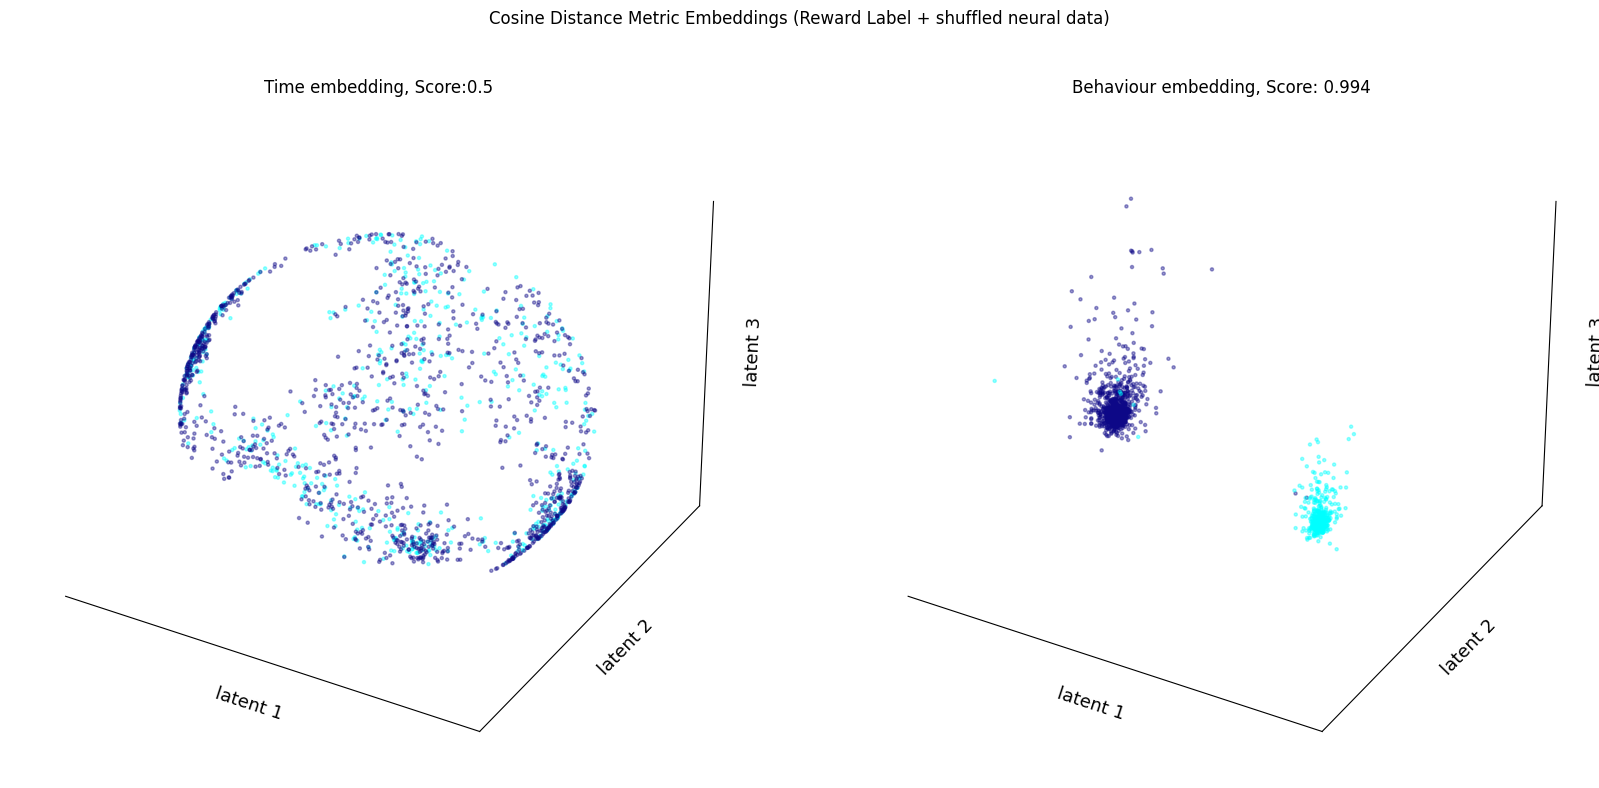

In [21]:
%matplotlib inline
# shuffled version
cp.view(shuffled_t_embed, shuffled_b_embed, labels=trial_labels, label_classes=[rewarded, unrewarded],  main_title = "Cosine Distance Metric Embeddings (Reward Label + shuffled neural data)")

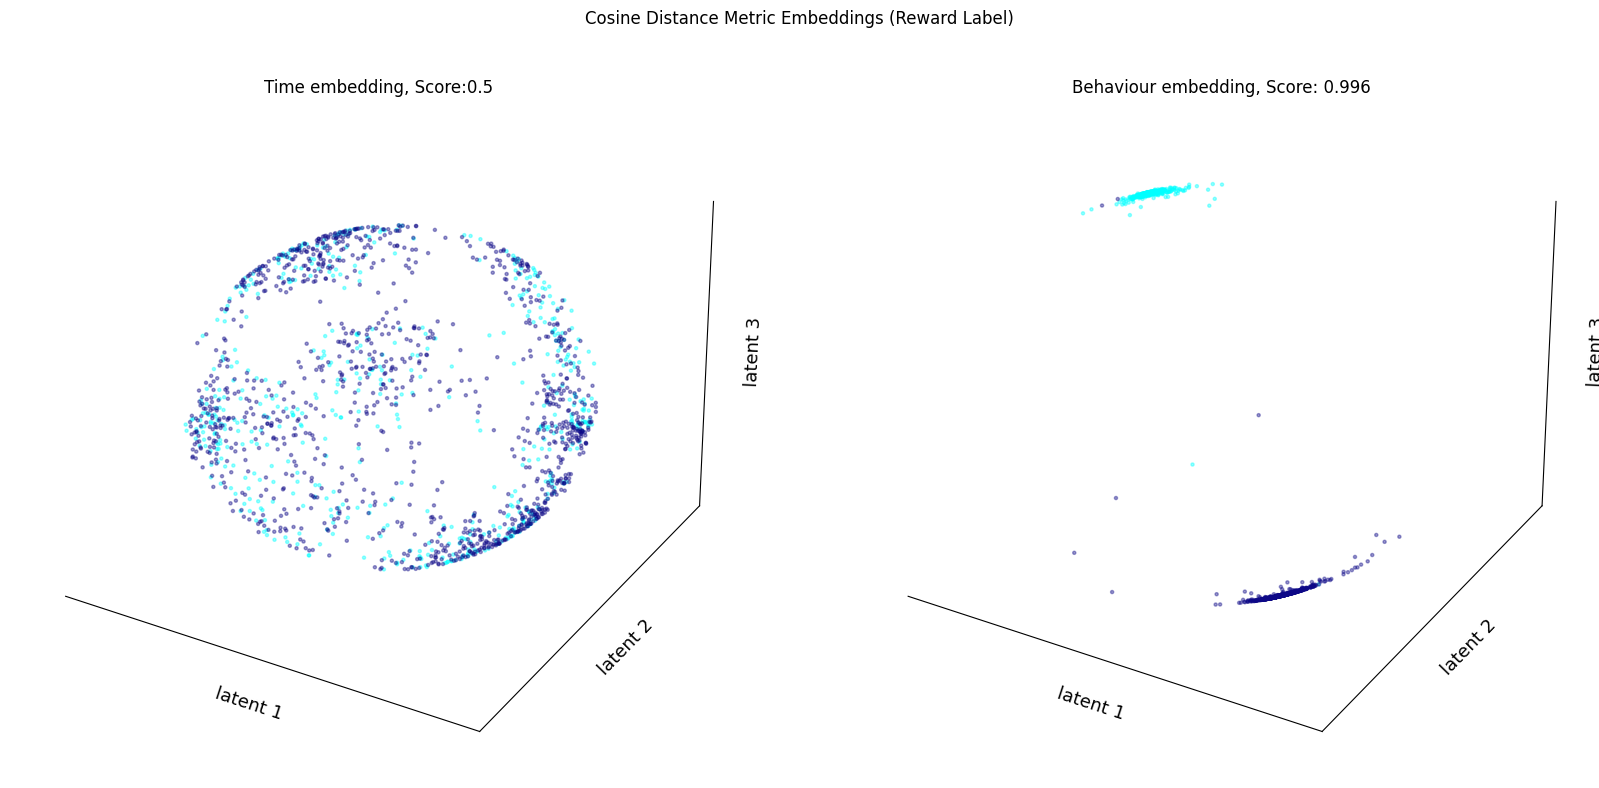

In [22]:
cp.view(t_embed, b_embed, labels=trial_labels, label_classes=[rewarded, unrewarded], main_title = "Cosine Distance Metric Embeddings (Reward Label)")

From these, it seems that shuffling the time-points within the trials decreases CEBRA's ability to decode the presence of reward in that trial.

## EUCLIDEAN DISTANCE COMPARISON

Here we confirm that the euclidean metric still gives the same performance. The embeddings will appear different, because unlike the cosine distance used before, the embeddings are not constrained to lie on the surface of a sphere.

In [23]:
# unshuffled
euc_t_embed, euc_b_embed = cp.build_train_compute(formatted_nms, trial_labels, arch='offset10-model-mse', metric='euclidean')

# shuffled
euc_shuffled_t_embed, euc_shuffled_b_embed = cp.build_train_compute(shuffled_nms, trial_labels, arch='offset10-model-mse', metric='euclidean')

pos:  0.9046 neg:  2.9284 total:  3.8330 temperature:  1.0000: 100%|██████████| 2000/2000 [00:14<00:00, 141.54it/s]
pos:  0.3077 neg:  5.4497 total:  5.7574 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 148.13it/s]
pos:  0.8262 neg:  2.8745 total:  3.7007 temperature:  1.0000: 100%|██████████| 2000/2000 [00:12<00:00, 157.75it/s]
pos:  0.2781 neg:  5.4958 total:  5.7739 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 151.09it/s]


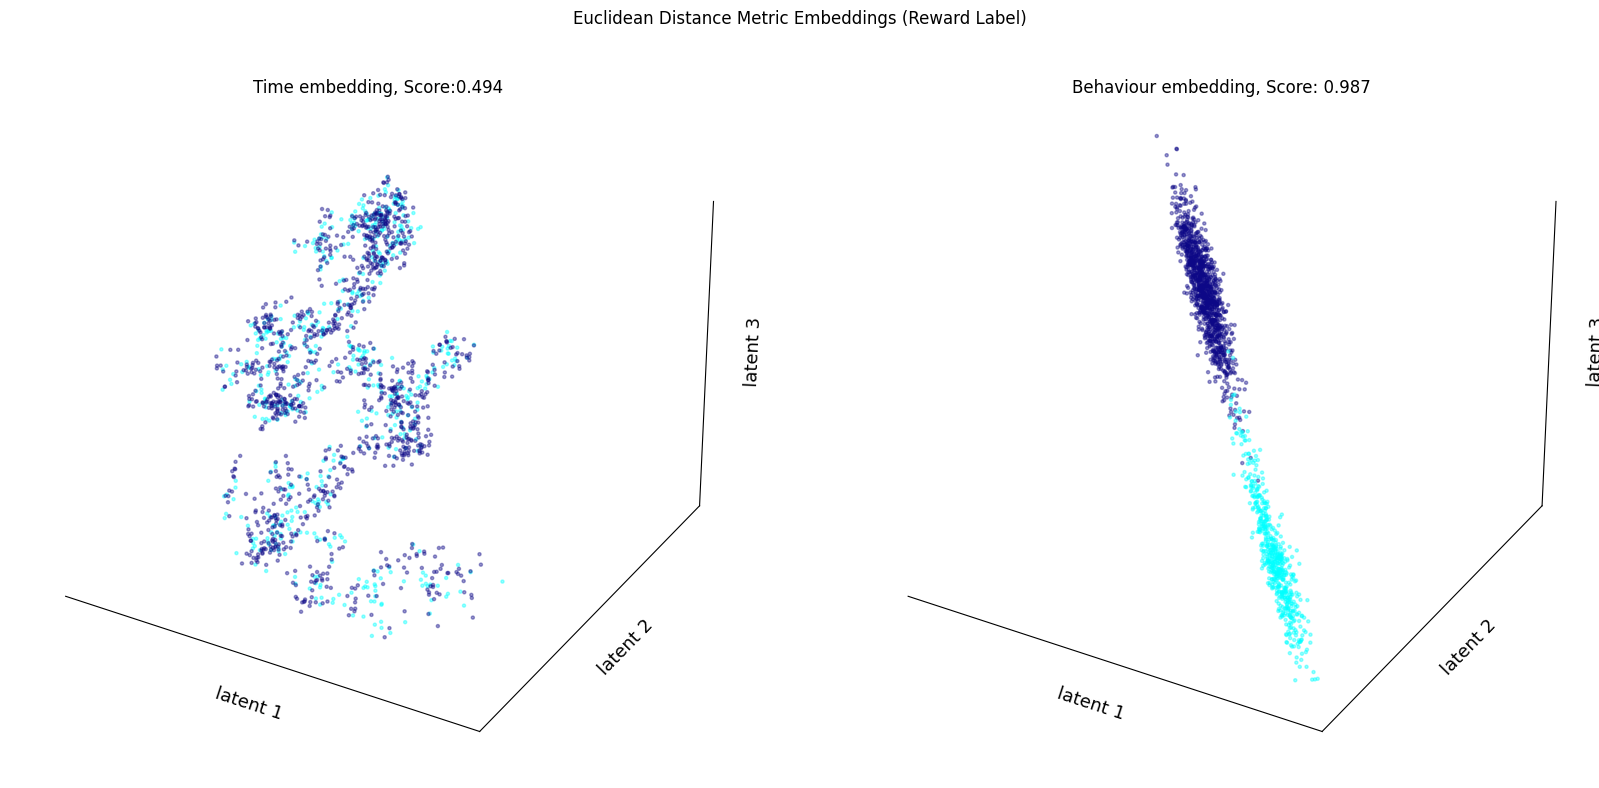

In [24]:
# unshuffled version
cp.view(euc_t_embed, euc_b_embed, labels=trial_labels, label_classes=[rewarded, unrewarded], main_title = "Euclidean Distance Metric Embeddings (Reward Label)")

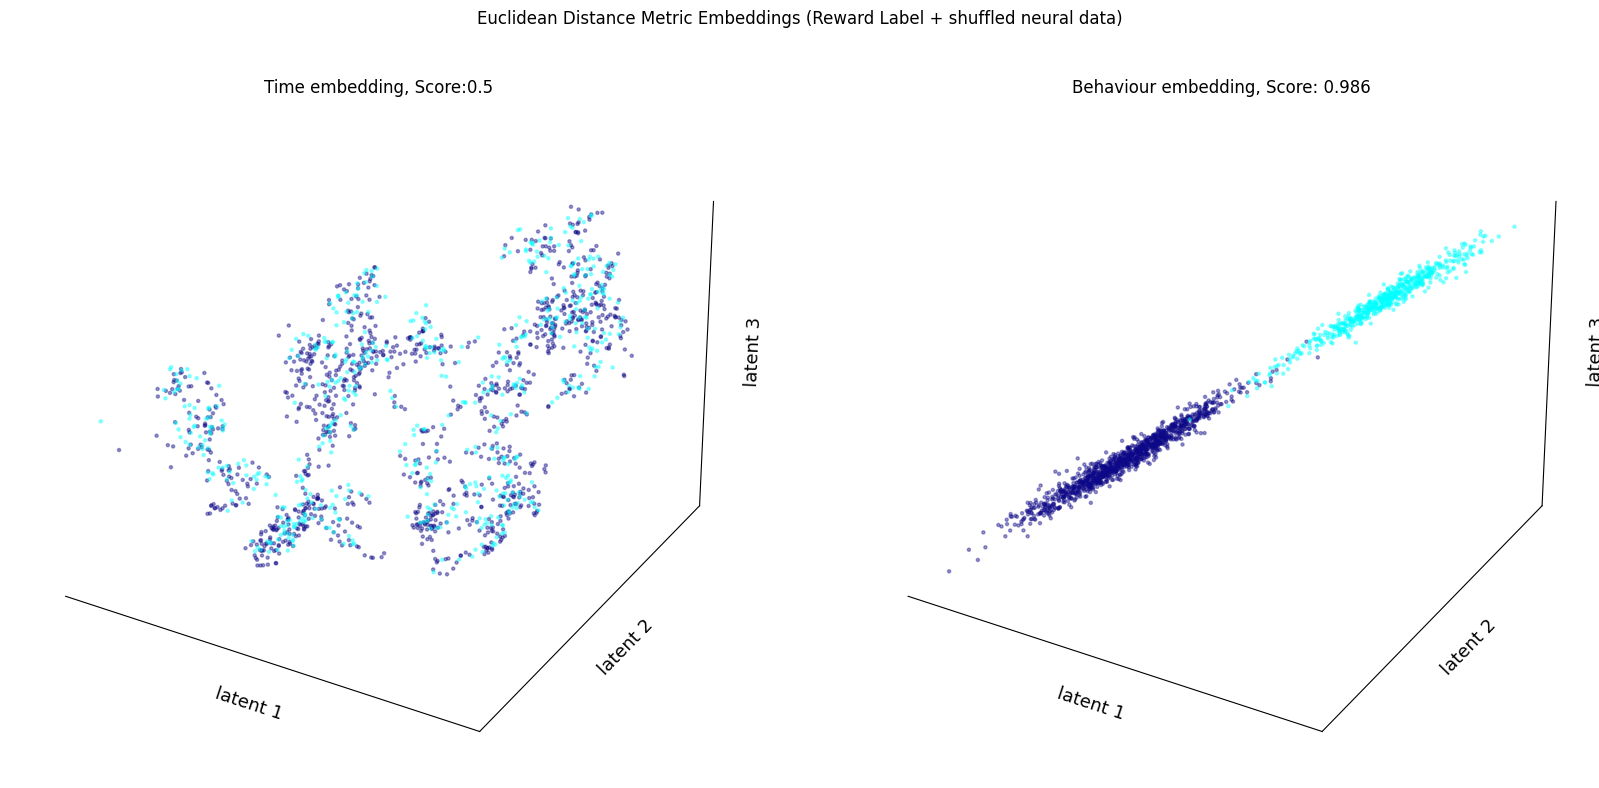

In [25]:
# shuffled version
cp.view(euc_shuffled_t_embed, euc_shuffled_b_embed, labels=trial_labels, label_classes=[rewarded, unrewarded], main_title = "Euclidean Distance Metric Embeddings (Reward Label + shuffled neural data)")

## HOW WELL DOES CEBRA OVERFIT NOISE?

Here, we shuffle the trials and see if CEBRA still recovers the trial labels correctly. If it does retrieve the original trial labels then we know that it overfits the noise.

In [28]:
shuf_trials_nms = formatted_nms[np.random.permutation(formatted_nms.shape[0]),:]

In [38]:
np.random.permutation(formatted_nms.shape[0])

array([ 208,  723,  612, ..., 1382, 1441,  905])

In [30]:
shuf_trials_t_embed, shuf_trials_b_embed = cp.build_train_compute(shuf_trials_nms, trial_labels)

pos:  0.4530 neg:  5.4298 total:  5.8828 temperature:  1.0000: 100%|██████████| 2000/2000 [00:12<00:00, 154.44it/s]
pos:  0.0004 neg:  6.2380 total:  6.2384 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 147.43it/s]


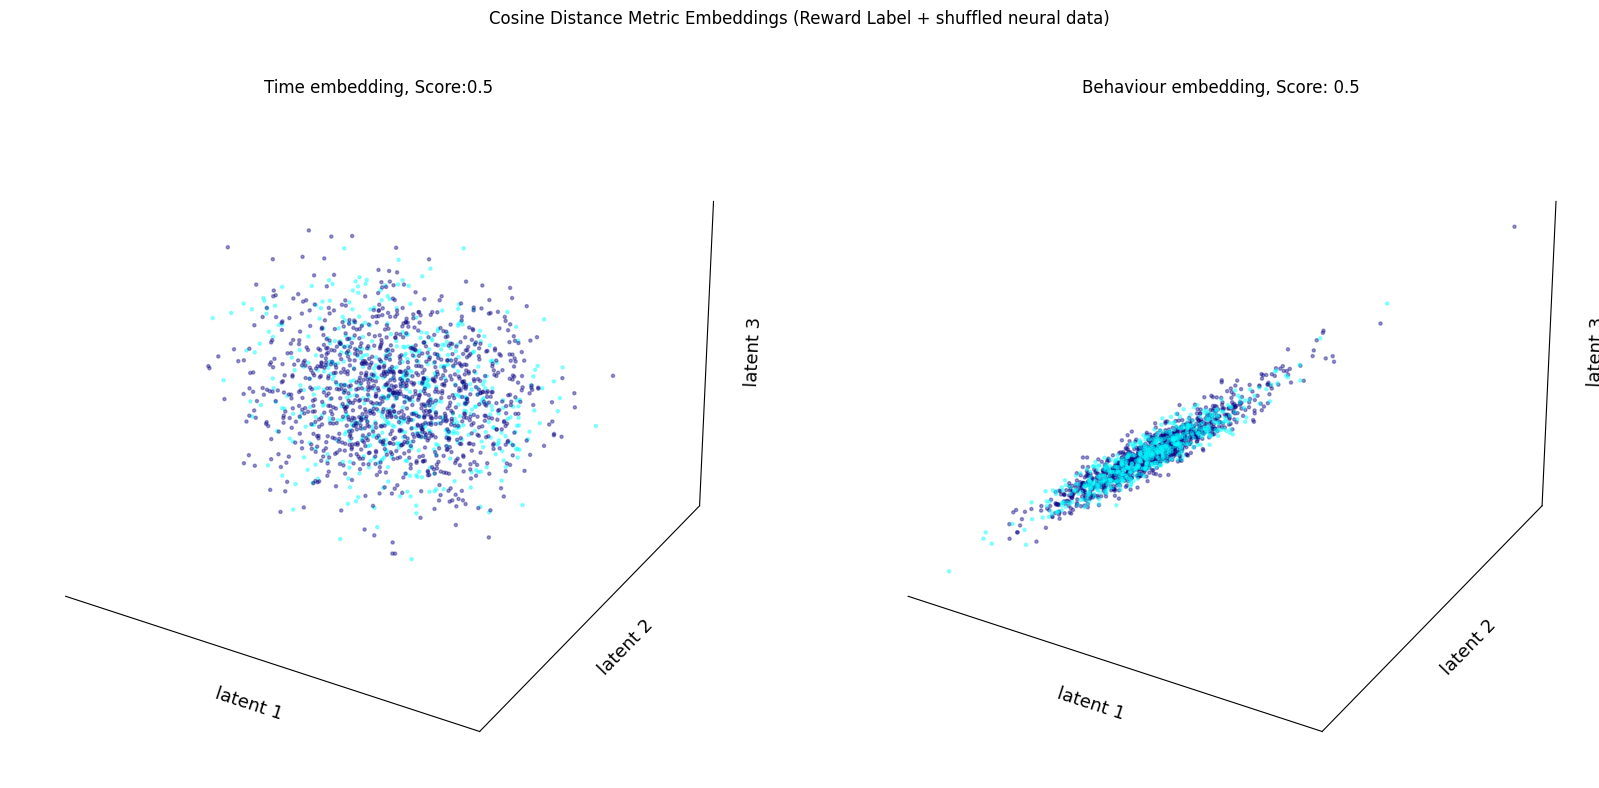

In [36]:
cp.view(shuf_trials_t_embed, shuf_trials_b_embed, labels=trial_labels, label_classes=[rewarded, unrewarded], main_title = "Cosine Distance Metric Embeddings (Reward Label + shuffled neural data)")

In [34]:
shuf_trials_t_embed2, shuf_trials_b_embed2 = cp.build_train_compute(shuf_trials_nms, trial_labels, arch='offset10-model-mse', metric='euclidean')

pos:  0.8414 neg:  4.6673 total:  5.5087 temperature:  1.0000: 100%|██████████| 2000/2000 [00:12<00:00, 157.04it/s]
pos:  0.0017 neg:  6.2365 total:  6.2383 temperature:  1.0000: 100%|██████████| 2000/2000 [00:13<00:00, 150.30it/s]


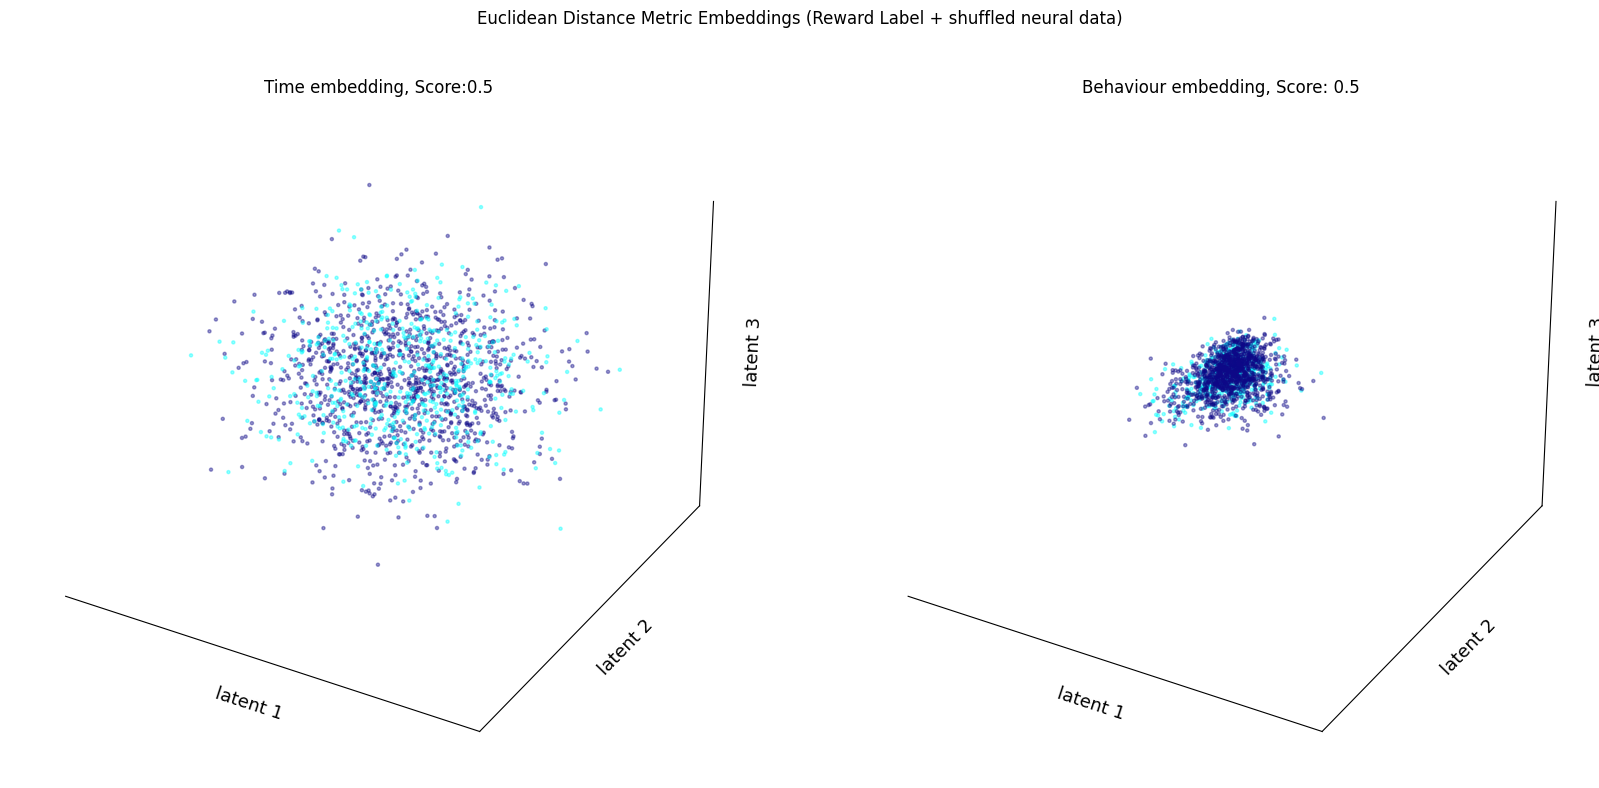

In [35]:
cp.view(shuf_trials_t_embed2, shuf_trials_b_embed2, labels=trial_labels, label_classes=[rewarded, unrewarded],  main_title="Euclidean Distance Metric Embeddings (Reward Label + shuffled neural data)")

Alright, so it looks like it does not overfit the noise at all -- which is a good thing (a bit too perfect, but it seems good for now).